# Malmquist bias
My sample is magnitude limited, and therefore subject to Malmquist bias. For a binary survey, the effect of Malmquist bias is to favor systems with large mass-ratios, since the companion has higher flux. Neglected all other sampling biases such as my vsini limit (which shouldn't introduce a strong bias), the probability of being in my sample is essentially:

\\[
P(obs) =
  \begin{cases}
    1 & \text{if } V < 6 \\
    0 & \text{otherwise}
  \end{cases}
\\]

Now V, the apparent V-band magnitude of the target, is of course a function of the distance ($\rho$) to the star and the absolute magnitude of the star:

$$ V = M_V + 5\log{\rho} - 5 $$

In the case of binary stars, the absolute magnitude is coming from the light of two stars with primary mass $M_1$ and companion mass $qM_1$:

$$ M_{v, total}(q, M_1) = -2.5\log{10^{-M_v(M_1)/2.5} + 10^{-M_v(qM_1)/2.5}} $$

The function $M_v(M)$ is the absolute magnitude of a main-sequence star with mass M, and can be interpolated from stellar evolution models or observational tables such as [this one](http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt). What we want is the probability that a given binary system has $V<6$, as a function of mass-ratio ($q$). Since the conversion from mass to absolute magnitude is not analytical, we will have to do this with a Monte Carlo simulation. We will draw random primary star masses from the Salpeter IMF:

$$P(M)dM \sim M^{-2.35}dM $$
 
Let's normalize it between the primary masses in my sample:

$$ 1 = A\int_{1.5}^{20} m^{-2.35}dm $$
$$ 1 = -\frac{A}{1.35}(20^{-1.35} - 1.5^{-1.35}) $$

In [1]:
# Calculate A
A = -1.35/(20**(-1.35) - 1.5**(-1.35))
print('A = {:.3f}'.format(A))

A = 2.407


The distance is a bit more complicated, but we will use data from the Hipparchos satellite to estimate the distribution of parallaxes to various stars. It is well fit by a log-normal distribution:

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (0,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


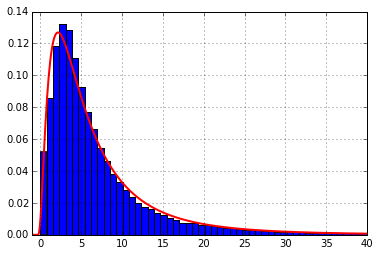

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
%matplotlib inline

hipparchos = pd.read_csv('data/hipparchos.tsv', sep='|', na_values=[' '], skipinitialspace=True)[2:].reset_index()
hipparchos.Plx = hipparchos.Plx.astype(float)
measured = hipparchos.dropna(subset=['Plx']).query('Plx > 0')
_ = measured.Plx.hist(bins=1000, normed=True)
plt.xlim(-1, 40)
plx_shape, plx_loc, plx_scale = scipy.stats.lognorm.fit(measured.Plx)
x = np.arange(-1, 100, 0.1)
y = scipy.stats.lognorm.pdf(x, s=plx_shape, scale=plx_scale, loc=plx_loc)
plt.plot(x, y, 'r-', lw=2)


The only thing left is to define $M_v(M)$. I will use the empirical table derived by Pecaut & Mamajek, and fit a 'functional' form by using a smoothing spline. I will hand-tweak the smoothing parameter such that the error is less than 0.1 dex.

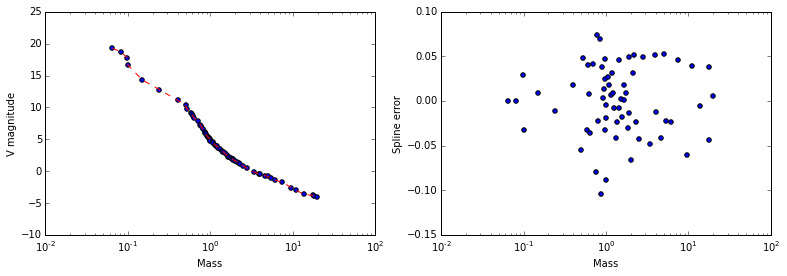

In [3]:
# Take a look at the relation between mass and V-band magnitude for main-sequence stars.
from Mamajek_Table import MamajekTable
import matplotlib.pyplot as plt

# Get the mamajek table. Sort by mass, and remove the NaNs
MT = MamajekTable()
df = MT.mam_df.dropna(subset=['Msun']).sort('Msun')
mass = df['Msun']
vmag = df['Mv']

# Interpolate the table with a smoothing spline.
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(mass, vmag, s=1e-1)
predicted = spline(mass)
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].scatter(mass, vmag)
axes[0].plot(mass, predicted, 'r--')
axes[1].scatter(mass, vmag-predicted)

axes[0].set_xlabel('Mass')
axes[0].set_ylabel('V magnitude')
axes[1].set_xlabel('Mass')
axes[1].set_ylabel('Spline error')


Finally, we are ready to find put everything together. I will sample 1 million points from the Salpeter IMF between 1.5 and 20 $M_{\odot}$ and 1 million parallaxes drawn from the log-normal distribution I fit to Hipparchos data. I will then loop over various values of the mass-ratio ($q$) and find the fraction of stars with $V<6$ as a function of mass-ratio.

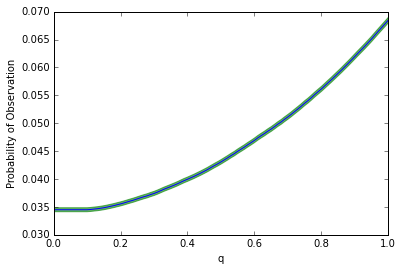

In [27]:
from __future__ import division
import IMF_utils
import HelperFunctions
reload(HelperFunctions)
from HelperFunctions import add_magnitudes, Binomialerrors
# Sample the distance and primary mass distributions, 
# and find the fraction that fall in my V-band limit as a function of q
N_total = 1e6

def Vmag(q, mass, d):
    """ Get the V-band magnitude as a function of mass-ratio (q), primary mass(mass),
        and distance (d)"""
    M1 = spline(mass)
    M2 = spline(q*mass)
    M_total = add_magnitudes(M1, M2)
    V = M_total + 5*np.log10(d) - 5
    return V

    

# Sample the distance through a log-normal parallax distribution (parameters fit to Hipparchos data)
#plx = scipy.stats.lognorm.rvs(loc=plx_loc, s=plx_shape, scale=plx_scale, size=N_total)
#plx[plx < 1e-5] = 1e-5
#distance = 1000. / plx

# Sample the distance such that a sphere around the Earth is uniformly distributed
distance = (np.random.uniform(size=N_total))**(1./3.) * 1000.0

# Sample the IMF
mass = IMF_utils.inverse_imf(np.random.uniform(size=N_total), mmin=1.5, mmax=20.0)

# Get the V_band magnitude
q = np.arange(0.0, 1.01, 0.01)
prob = np.zeros(q.size)
prob_low = np.zeros(q.size)
prob_high = np.zeros(q.size)
for i, qi in enumerate(q):
    V = Vmag(qi, mass, distance)
    prob[i], prob_low[i], prob_high[i] = Binomialerrors(len(V[V<6]), len(V))
    #prob[i] = len(V[V<6]) / len(V)

# We can't go all the way to zero because the V-magnitude interpolation starts extrapolating
# Instead, assume that P(obs|q<0.1) = P(obs|q)
idx = np.argmin((q - 0.1)**2)
prob[:idx] = prob[idx]
prob_low[:idx] = prob_low[idx]
prob_high[:idx] = prob_high[idx]
    
plt.plot(q, prob)
plt.fill_between(q, prob_low, prob_high, color='green', alpha=0.6)
plt.xlabel('q')
plt.ylabel('Probability of Observation')


         4           3           2
0.01543 x - 0.03116 x + 0.05275 x - 0.002677 x + 0.0342


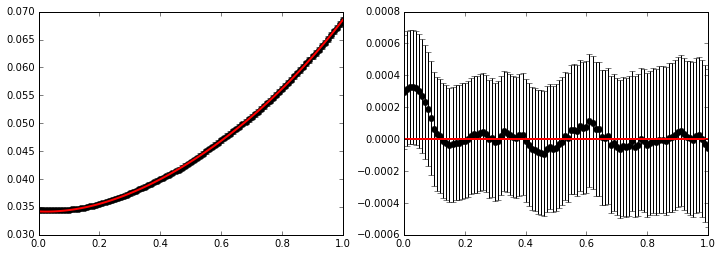

In [38]:
fit = np.poly1d(np.polyfit(q[q>0.1], prob[q>0.1], 4))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].errorbar(q, prob, yerr=(prob-prob_low, prob_high-prob), fmt='ko')
axes[0].plot(q, fit(q), 'r-', lw=2)

#axes[1].scatter(q, (prob - fit(q))/prob*100)
axes[1].errorbar(q, prob-fit(q), yerr=(prob-prob_low, prob_high-prob), fmt='ko')
axes[1].plot(q, np.zeros_like(q), 'r-', lw=2)
#axes[1].set_ylim((-0.001, 0.001))
print fit

As expected, the probability of observing a binary system increases with mass-ratio. But that isn't *quite* what I need. What I need is the probability of getting a given mass-ratio, given that I observed it.

$$ P(q|obs) = \frac{P(obs|q)P(q)}{\int P(obs|q)P(q)dq} $$

But $P(q)$ is *precisely* what I am trying to measure in the first place! Grrr. Let's make sure this looks right by using the power law from De Rosa et al (2014).

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in power
  from IPython.kernel.zmq import kernelapp as app


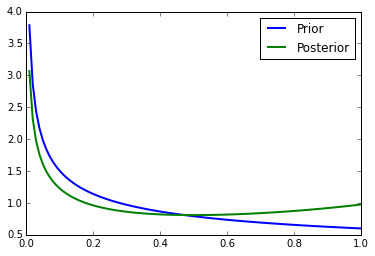

In [39]:
def prior(q, gamma=0.4):
    return (1-gamma)*q**(-gamma)

# Interpolate P(obs|q) (the plot above)
#Pobs = UnivariateSpline(q, prob, s=0, k=1)
Pobs = fit

# Integrate the bottom
from scipy.integrate import quad
denominator, _ = quad(lambda x: Pobs(x)*prior(x), 0, 1)

# Now, calculate P(q|obs) from Baye's theorem.
Pq = Pobs(q)*prior(q) / denominator

%matplotlib inline
plt.plot(q, prior(q), lw=2, label='Prior')
plt.plot(q, Pq, lw=2, label='Posterior')
plt.legend(loc='best')

That still gives the expected result, in that the mass-ratio distribution becomes skewed towards high mass-ratios. I will have to take an iterative approach in which I calculate the Malmquist bias from the current MRD parameter(s) and then repeat until the parameter no longer changes by much.

## Malmquist bias also affects the overal binary frequency I measure!
Since binary stars will be systematically biased towards lower magnitudes, my survey is also biased towards any binary stars. That was kind of why I did it as a magnitude limit in the first place, but I will still need to correct for that!